### This notebook plays around with node degrees and looks at the impact of systematically deleting SC ...

#### In this notebook (based on the convo with "Dave"), I try to isolate the different FC NTwx, but strcuturally. 
##### I will then run whobpyt on these structurally isolated ntwx to see how it affects FC, potentially shedding some light on how FC ntwx emerge. 

##### 'structurally isolate' means virtual lesions that make the regions of the a given network (eg: DMN) only have connections to itself.   
##### Essentially, you set the conncetions of the DMN regions/parcels with other ntwx to 0 in the SC mtx.  

##### All of the above will be first attempted for a single subject.  
##### This NB uses a resolution of 200 Schaefer parcellations.  

In [103]:
# Importage
import warnings
warnings.filterwarnings('ignore')

# os stuff
import os
import sys

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

import seaborn as sns

# whobpyt stuff
import whobpyt
from whobpyt.data.dataload import dataloader
# from whobpyt.models.jansen_rit import RNNJANSEN
from whobpyt.models.wong_wang import RNNRWW
from whobpyt.datatypes.modelparameters import ParamsModel
from whobpyt.optimization.modelfitting import Model_fitting

# array and pd stuff
import numpy as np
import pandas as pd

# viz stuff
import matplotlib.pyplot as plt

In [11]:
from collections import Counter

In [12]:
import pickle

In [13]:
parcs = np.arange(0,200,1)

mask = np.tril_indices(len(parcs), -1)

# Labels
_label_file =  '/external/rprshnas01/kcni/hharita/Code/whobpyt/scratch/Schaefer200_7_Ntwx_labels.txt'

f = open(_label_file, "r")
q = f.read()
q = q.rsplit('\n')
# del q[-32:]
labels = q.copy()
labels = np.array(labels)
labels = labels[parcs]


In [14]:
import re

In [15]:
folder_one_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II'
folder_two_path = SCs_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Improved_WWD_HCP_model_runs/All_Subs_SC_Wts/Davide_HCP_Data_Matrix'

# Get the list of files in each folder
folder_one_files = os.listdir(folder_one_path)
folder_two_files = os.listdir(folder_two_path)

# Extract the numbers from the filenames in folder_one
folder_one_numbers = []
for file in folder_one_files:
    match = re.search(r'\d+', file)
    if match:
        folder_one_numbers.append(int(match.group()))

# Extract the numbers from the filenames in folder_two
folder_two_numbers = []
for file in folder_two_files:
    match = re.search(r'\d+', file)
    if match:
        folder_two_numbers.append(int(match.group()))

# Find the common numbers between the two folders
common_numbers = list(set(folder_one_numbers) & set(folder_two_numbers))

sub_list = common_numbers.copy()

sub_list.sort()

sub_list = sub_list[0:200]

In [31]:
pconn_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/Shrey_SS_parcellated_Func_Conns_II/'

In [32]:
def emp_fc(sub_id):
    pconn1LR = pconn_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_parcellated.ptseries.nii'.format(sub_id)
    pconn_img1LR = nib.load(pconn1LR)
    pconn_dat1LR = pconn_img1LR.get_data()
    pconn_dat1LR = pconn_dat1LR/1
    return pconn_dat1LR

In [33]:
%%time

all_subs_emp_fc = []
for i in range(len(sub_list)):
    ss_emp_fc = emp_fc(sub_list[i])
    all_subs_emp_fc.append(ss_emp_fc)

CPU times: user 1min 5s, sys: 853 ms, total: 1min 6s
Wall time: 1min 21s


In [37]:
%%time
all_subs_emp_fc_mat = []
for i in range(200):
    all_subs_emp_fc_mat.append(np.corrcoef(all_subs_emp_fc[i].T))

CPU times: user 1.43 s, sys: 166 ms, total: 1.59 s
Wall time: 1.82 s


In [16]:
og_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/200_subjects_WhoBPyT_run'
lesion_whobpyt_path = '/external/rprshnas01/netdata_kcni/jglab/MemberSpaces/Data/Shrey/WhoBPyT/Ntwx_Lesion_WhoBPyT_200_subs'

In [17]:
# Subj_164030_vis_lesion_cc_cut_fc_con_mat.txt
# Subj_164030_vis_lesion_fc_con_mat.txt

###  Takes 45 mins ... strap in!

In [9]:
%%time

all_subs_og_whobpyt = []

all_subs_vis_lesion = []
all_subs_vis_lesion_cc_cut = []

all_subs_sommot_lesion = []
all_subs_sommot_lesion_cc_cut = []

all_subs_dorsattn_lesion = []
all_subs_dorsattn_lesion_cc_cut = []

all_subs_ventattn_lesion = []
all_subs_ventattn_lesion_cc_cut = []

all_subs_limbic_lesion = []
all_subs_limbic_lesion_cc_cut = []

all_subs_fpn_lesion = []
all_subs_fpn_lesion_cc_cut = []

all_subs_dmn_lesion = []
all_subs_dmn_lesion_cc_cut = []

for i in range(len(sub_list)):
    
    sub_id = sub_list[i]
    
    ss_og_whobpyt = np.loadtxt(og_whobpyt_path + '/{0}_whobypt_fc_mtx.txt'.format(sub_id))
    all_subs_og_whobpyt.append(ss_og_whobpyt)
    
    ss_vis_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_fc_con_mat.txt'.format(sub_id))
    ss_vis_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_vis_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_vis_lesion.append(ss_vis_lesion)
    all_subs_vis_lesion_cc_cut.append(ss_vis_lesion_cc_cut)
    

    ss_sommot_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_fc_con_mat.txt'.format(sub_id))
    ss_sommot_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_sommot_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_sommot_lesion.append(ss_sommot_lesion)
    all_subs_sommot_lesion_cc_cut.append(ss_sommot_lesion_cc_cut)

    ss_dorsattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dorsattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dorsattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dorsattn_lesion.append(ss_dorsattn_lesion)
    all_subs_dorsattn_lesion_cc_cut.append(ss_dorsattn_lesion_cc_cut)
    

    ss_ventattn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_ventattn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_ventattn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_ventattn_lesion.append(ss_ventattn_lesion)
    all_subs_ventattn_lesion_cc_cut.append(ss_ventattn_lesion_cc_cut)

    
    ss_limbic_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_fc_con_mat.txt'.format(sub_id))
    ss_limbic_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_limbic_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_limbic_lesion.append(ss_limbic_lesion)
    all_subs_limbic_lesion_cc_cut.append(ss_limbic_lesion_cc_cut)

    
    ss_fpn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_fpn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_fpn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_fpn_lesion.append(ss_fpn_lesion)
    all_subs_fpn_lesion_cc_cut.append(ss_fpn_lesion_cc_cut)

    
    ss_dmn_lesion = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_fc_con_mat.txt'.format(sub_id))
    ss_dmn_lesion_cc_cut = np.loadtxt(lesion_whobpyt_path + '/Subj_{0}_dmn_lesion_cc_cut_fc_con_mat.txt'.format(sub_id))
    all_subs_dmn_lesion.append(ss_dmn_lesion)
    all_subs_dmn_lesion_cc_cut.append(ss_dmn_lesion_cc_cut)

CPU times: user 2min 42s, sys: 4.09 s, total: 2min 46s
Wall time: 5min 43s


In [20]:
# for now deal with avg fc of DMN lesion only (across all ntwx) ...
# This is INNER connectivity ... i.e., the average ntwx conn to itself (so Vis to Vis, DMN to DMN, etc)

# all_subs_og_whobpyt
# all_subs_dmn_lesion

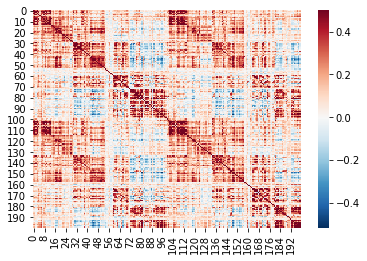

In [42]:
sns.heatmap(all_subs_emp_fc_mat[4], cmap='RdBu_r',center=0,vmax=0.5)

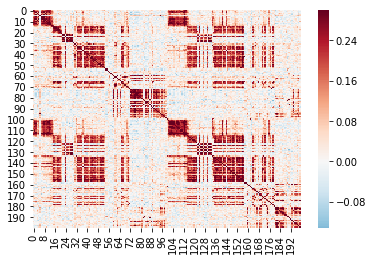

In [29]:
sns.heatmap(all_subs_og_whobpyt[4], cmap='RdBu_r',center=0,vmax=0.3)

In [50]:
corrs_list = []
for i in range(200):
    corrs_list.append(np.corrcoef(all_subs_emp_fc_mat[i][mask], all_subs_og_whobpyt[i][mask])[0][1])

In [68]:
# corrs_list

[0.6200089167105477,
 0.6102467277725079,
 0.6647353853416271,
 0.6105464220191049,
 0.5379972089268263,
 0.675883045094604,
 0.6239469367464171,
 0.6132007413933916,
 0.5837859181933756,
 0.6492939860396871,
 0.7374194244219163,
 0.6710034619810292,
 0.5394807075259581,
 0.5806288462428778,
 0.5982522049650677,
 0.6366729218134846,
 0.6030707053415126,
 0.6572905193196694,
 0.6010094762339514,
 0.6488142220173515,
 0.5245148072609505,
 0.6565371180433753,
 0.5781901714645522,
 0.6217488344580433,
 0.5966773773493769,
 0.6554716971703077,
 0.5576062751599197,
 0.5865148566711488,
 0.5542586436140655,
 0.6609837658617055,
 0.6338557861231642,
 0.548438190044074,
 0.5830333296724894,
 0.6248622556172462,
 0.5231213312296725,
 0.6002683514745389,
 0.6045090645767037,
 0.5331416099239052,
 0.6089704590386142,
 0.584712181942719,
 0.5732585860625157,
 0.7285941975321231,
 0.6512142453917102,
 0.5238308575442,
 0.6058819571026307,
 0.5924403190323927,
 0.5892441829996325,
 0.5669979812301901

In [149]:
# ntwx_only_lh[(ntwx_only_lh>0.1)] # & (ntwx_only_rh<0.9)

In [184]:
fc = all_subs_og_whobpyt
sub = 147
a = 54
b = 60
c = 158
d = 164


In [185]:
ntwx_only_lh = fc[sub][a:b, a:b]
ntwx_only_rh = fc[sub][c:d, c:d]

ntwx_only_lhrh = fc[sub][a:b, c:d]
ntwx_only_rhlh = fc[sub][c:d, a:b]

In [186]:
ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>0.1)]


In [187]:
ntwx_only_lh

array([1.        , 0.85091794, 0.19923905, 0.85091794, 1.        ,
       0.19096105, 1.        , 0.80467299, 0.73434531, 0.80467299,
       1.        , 0.53763105, 0.73434531, 0.53763105, 1.        ,
       0.19923905, 0.19096105, 1.        ])

In [188]:
def ntwx_only_fc_with_thresh(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>0.1)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh>0.1)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh>0.1)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh>0.1)]
    
    # Replace NaN values with 0 in ntwx_only_lh
    ntwx_only_lh[np.isnan(ntwx_only_lh)] = 0

    # Replace NaN values with 0 in ntwx_only_rh
    ntwx_only_rh[np.isnan(ntwx_only_rh)] = 0

    # Replace NaN values with 0 in ntwx_only_lhrh
    ntwx_only_lhrh[np.isnan(ntwx_only_lhrh)] = 0

    # Replace NaN values with 0 in ntwx_only_rhlh
    ntwx_only_rhlh[np.isnan(ntwx_only_rhlh)] = 0
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [71]:
def ntwx_only_fc(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_rh = fc[sub][c:d, c:d]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [ ]:
# vis --> (0,14,100,115)
# sommot --> (14,30,115,134)
# dorsattn --> (30,43,134,147)
# ventattn --> (43,54,147,158)
# limbic --> (54,60,158,164)
# fpn --> (60,73,164,181)
# dmn --> (73,100,181,200)

In [113]:
Ntwx = ['Vis', 'SomMot', 'DorsAttn', 'VentAttn', 'Limbic', 'FPN', 'DMN']

#### original whobpyt

In [162]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs = []
org_whobpyt_sommot_mean_fc_all_subs = []
org_whobpyt_dorsattn_mean_fc_all_subs = []
org_whobpyt_ventattn_mean_fc_all_subs = []
org_whobpyt_limbic_mean_fc_all_subs = []
org_whobpyt_fpn_mean_fc_all_subs = []
org_whobpyt_dmn_mean_fc_all_subs = []

for i in range(200):
    
    temp_vis = ntwx_only_fc(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs.append(temp_vis)
    
    temp_sommot = ntwx_only_fc(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs.append(temp_ventattn)

    temp_limbic = ntwx_only_fc(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs.append(temp_limbic)

    temp_fpn = ntwx_only_fc(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs.append(temp_fpn)

    temp_dmn = ntwx_only_fc(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs)
org_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs)
org_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs)
org_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs)
org_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(org_whobpyt_limbic_mean_fc_all_subs)
org_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs)
org_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs)


org_whobpyt_means = [org_whobpyt_vis_mean_fc_all_subs_mean,
org_whobpyt_sommot_mean_fc_all_subs_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_mean,
org_whobpyt_ventattn_mean_fc_all_subs_mean,
org_whobpyt_limbic_mean_fc_all_subs_mean,
org_whobpyt_fpn_mean_fc_all_subs_mean,
org_whobpyt_dmn_mean_fc_all_subs_mean]

CPU times: user 145 ms, sys: 18.5 ms, total: 163 ms
Wall time: 149 ms


In [163]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

In [198]:
def func_for_inner_ntwx_connectivity(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_vis_mean_fc_all_subs)
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs)
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs)
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.mean(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs)


    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means

In [199]:
vis_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_vis_lesion)
sommot_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means = func_for_inner_ntwx_connectivity(all_subs_dmn_lesion)

####  Visual

In [202]:
org_whobpyt_means

[0.2381039300052709,
 0.18159082694176334,
 0.21459717983754742,
 0.19481845006681628,
 0.11863332314529478,
 0.12874539763860968,
 0.1304547462593384]

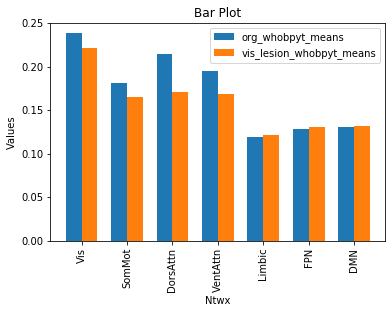

In [203]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means, width, label='vis_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Sommot

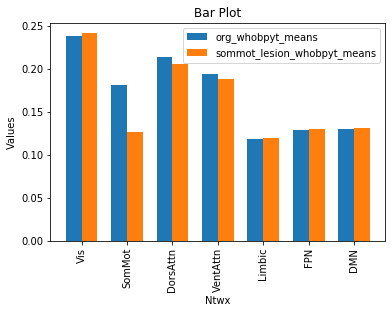

In [204]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means, width, label='sommot_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Dorsattn

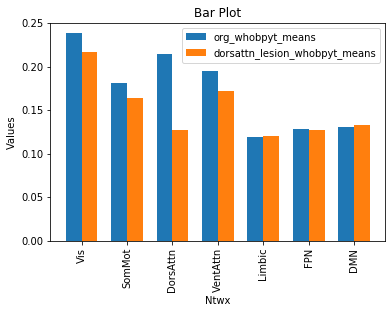

In [205]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means, width, label='dorsattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Ventattn

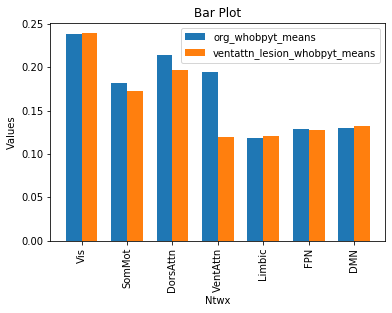

In [206]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means, width, label='ventattn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### Limbic

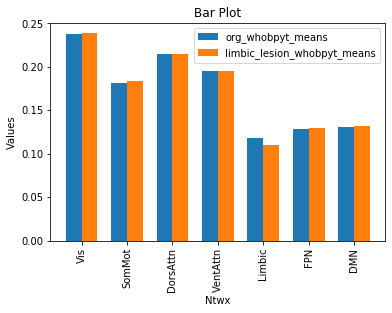

In [207]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means, width, label='limbic_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### FPN

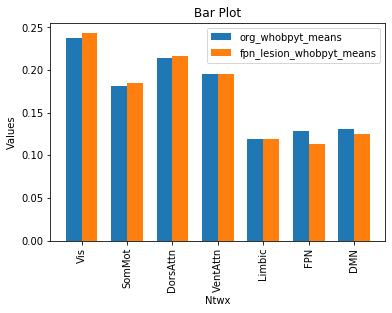

In [208]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means, width, label='fpn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

#### DMN lesion

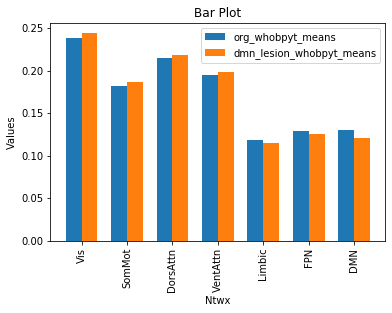

In [209]:
# Creating the bar plot
x = range(len(org_whobpyt_means))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means, width, label='org_whobpyt_means')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means, width, label='dmn_lesion_whobpyt_means')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend()

# Displaying the plot
plt.show()

## -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

### With threshold (>0.1, etc)

In [233]:
def ntwx_only_fc_with_thresh(fc, sub, a,b,c,d):
    
    ntwx_only_lh = fc[sub][a:b, a:b]
    ntwx_only_lh = ntwx_only_lh[(ntwx_only_lh>0.2)]
    
    ntwx_only_rh = fc[sub][c:d, c:d]
    ntwx_only_rh = ntwx_only_rh[(ntwx_only_rh>0.2)]

    ntwx_only_lhrh = fc[sub][a:b, c:d]
    ntwx_only_lhrh = ntwx_only_lhrh[(ntwx_only_lhrh>0.2)]
    
    ntwx_only_rhlh = fc[sub][c:d, a:b]
    ntwx_only_rhlh = ntwx_only_rhlh[(ntwx_only_rhlh>0.2)]
    
    # Replace NaN values with 0 in ntwx_only_lh
    ntwx_only_lh[np.isnan(ntwx_only_lh)] = 0

    # Replace NaN values with 0 in ntwx_only_rh
    ntwx_only_rh[np.isnan(ntwx_only_rh)] = 0

    # Replace NaN values with 0 in ntwx_only_lhrh
    ntwx_only_lhrh[np.isnan(ntwx_only_lhrh)] = 0

    # Replace NaN values with 0 in ntwx_only_rhlh
    ntwx_only_rhlh[np.isnan(ntwx_only_rhlh)] = 0
    
    mean_fc = (np.mean(ntwx_only_lh) + np.mean(ntwx_only_rh) + np.mean(ntwx_only_lhrh) + np.mean(ntwx_only_rhlh))/4
    
    return mean_fc

In [234]:
%%time

# original whobpyt

org_whobpyt_vis_mean_fc_all_subs_thresh = []
org_whobpyt_sommot_mean_fc_all_subs_thresh = []
org_whobpyt_dorsattn_mean_fc_all_subs_thresh = []
org_whobpyt_ventattn_mean_fc_all_subs_thresh = []
org_whobpyt_limbic_mean_fc_all_subs_thresh = []
org_whobpyt_fpn_mean_fc_all_subs_thresh = []
org_whobpyt_dmn_mean_fc_all_subs_thresh = []

for i in range(200):
    
    temp_vis = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 0, 14, 100, 115)
    org_whobpyt_vis_mean_fc_all_subs_thresh.append(temp_vis)
    
    temp_sommot = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 14, 30, 115, 134)
    org_whobpyt_sommot_mean_fc_all_subs_thresh.append(temp_sommot)

    temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 30, 43, 134, 147)
    org_whobpyt_dorsattn_mean_fc_all_subs_thresh.append(temp_dorsattn)

    temp_ventattn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 43, 54, 147, 158)
    org_whobpyt_ventattn_mean_fc_all_subs_thresh.append(temp_ventattn)

    temp_limbic = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 54, 60, 158, 164)
    org_whobpyt_limbic_mean_fc_all_subs_thresh.append(temp_limbic)

    temp_fpn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 60, 73, 164, 181)
    org_whobpyt_fpn_mean_fc_all_subs_thresh.append(temp_fpn)

    temp_dmn = ntwx_only_fc_with_thresh(all_subs_og_whobpyt, i, 73, 100, 181, 200)
    org_whobpyt_dmn_mean_fc_all_subs_thresh.append(temp_dmn)

    
    
    
org_whobpyt_vis_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_vis_mean_fc_all_subs_thresh)
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_sommot_mean_fc_all_subs_thresh)
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_dorsattn_mean_fc_all_subs_thresh)
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_ventattn_mean_fc_all_subs_thresh)
# issue affected limbic ntwx only ...
# hence the custom fix ...
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean = np.nanmean(np.nan_to_num(org_whobpyt_limbic_mean_fc_all_subs_thresh, nan=0))
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_fpn_mean_fc_all_subs_thresh)
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean = np.mean(org_whobpyt_dmn_mean_fc_all_subs_thresh)


org_whobpyt_means_with_thresh = [org_whobpyt_vis_mean_fc_all_subs_thresh_mean,
org_whobpyt_sommot_mean_fc_all_subs_thresh_mean,
org_whobpyt_dorsattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_ventattn_mean_fc_all_subs_thresh_mean,
org_whobpyt_limbic_mean_fc_all_subs_thresh_mean,
org_whobpyt_fpn_mean_fc_all_subs_thresh_mean,
org_whobpyt_dmn_mean_fc_all_subs_thresh_mean]

CPU times: user 200 ms, sys: 13.1 ms, total: 213 ms
Wall time: 212 ms


In [235]:
org_whobpyt_means_with_thresh

[0.3225652402819775,
 0.3293675562662064,
 0.32179349039214755,
 0.3431598550431624,
 0.1996681854001493,
 0.3634565857318436,
 0.331805035251335]

#### with thresh

In [239]:
def func_for_inner_ntwx_connectivity_with_thresh(all_subs_ntwx_lesion):
    
    # lesion (DMN) whobpyt

    ntwx_lesion_whobpyt_vis_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs = []
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs = []

    for i in range(200):

        ntwx_lesion_temp_vis = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 0, 14, 100, 115)
        ntwx_lesion_whobpyt_vis_mean_fc_all_subs.append(ntwx_lesion_temp_vis)

        ntwx_lesion_temp_sommot = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 14, 30, 115, 134)
        ntwx_lesion_whobpyt_sommot_mean_fc_all_subs.append(ntwx_lesion_temp_sommot)

        ntwx_lesion_temp_dorsattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 30, 43, 134, 147)
        ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs.append(ntwx_lesion_temp_dorsattn)

        ntwx_lesion_temp_ventattn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 43, 54, 147, 158)
        ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs.append(ntwx_lesion_temp_ventattn)

        ntwx_lesion_temp_limbic = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 54, 60, 158, 164)
        ntwx_lesion_whobpyt_limbic_mean_fc_all_subs.append(ntwx_lesion_temp_limbic)

        ntwx_lesion_temp_fpn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 60, 73, 164, 181)
        ntwx_lesion_whobpyt_fpn_mean_fc_all_subs.append(ntwx_lesion_temp_fpn)

        ntwx_lesion_temp_dmn = ntwx_only_fc_with_thresh(all_subs_ntwx_lesion, i, 73, 100, 181, 200)
        ntwx_lesion_whobpyt_dmn_mean_fc_all_subs.append(ntwx_lesion_temp_dmn)


    ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_vis_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_sommot_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_limbic_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_fpn_mean_fc_all_subs, nan=0))
    
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean = np.nanmean(np.nan_to_num(ntwx_lesion_whobpyt_dmn_mean_fc_all_subs, nan=0))


    ntwx_lesion_whobpyt_means = [ntwx_lesion_whobpyt_vis_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_sommot_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dorsattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_ventattn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_limbic_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_fpn_mean_fc_all_subs_mean,
    ntwx_lesion_whobpyt_dmn_mean_fc_all_subs_mean]
    
    return ntwx_lesion_whobpyt_means

In [240]:
vis_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_vis_lesion)
sommot_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_sommot_lesion)
dorsattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dorsattn_lesion)
ventattn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_ventattn_lesion)
limbic_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_limbic_lesion)
fpn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_fpn_lesion)
dmn_lesion_whobpyt_means_with_thresh = func_for_inner_ntwx_connectivity_with_thresh(all_subs_dmn_lesion)

### With threshold (>0.1) figures

#### Visual

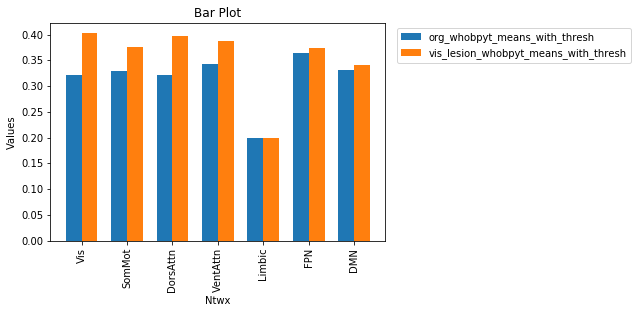

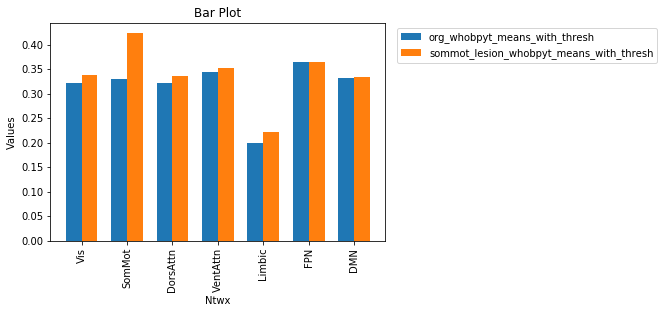

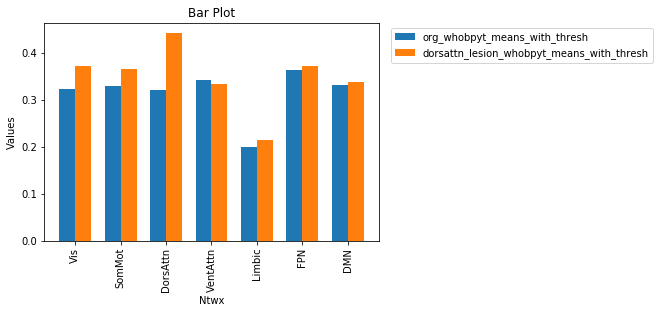

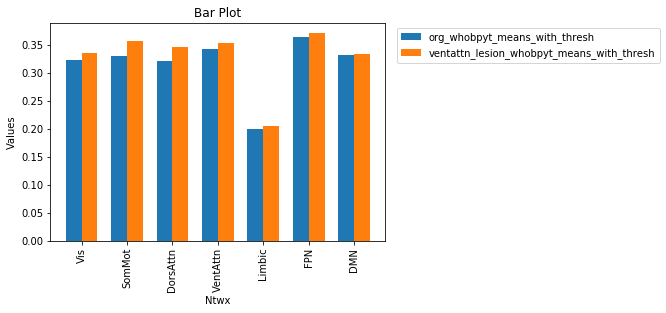

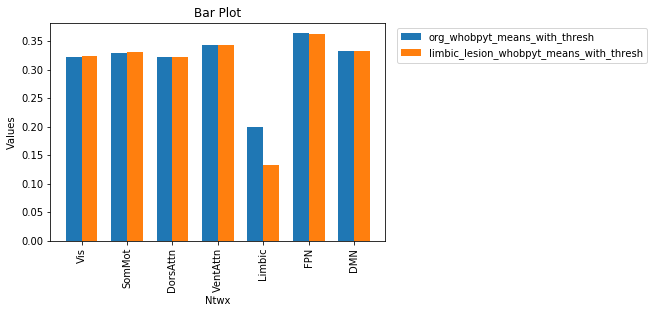

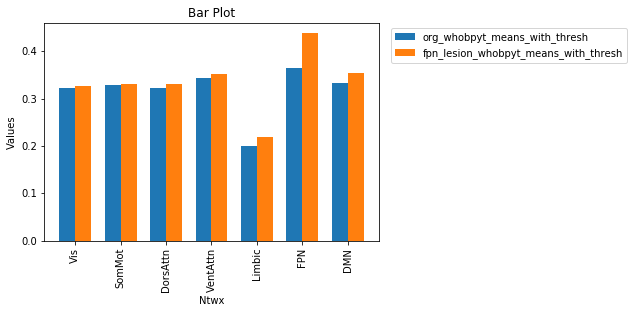

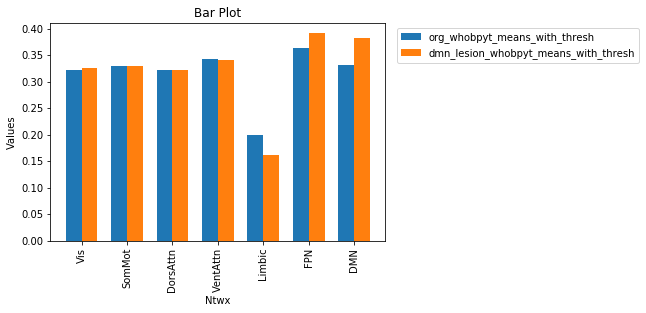

In [241]:
# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], vis_lesion_whobpyt_means_with_thresh, width, label='vis_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Sommot

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], sommot_lesion_whobpyt_means_with_thresh, width, label='sommot_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

#### Dorsattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dorsattn_lesion_whobpyt_means_with_thresh, width, label='dorsattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Ventattn

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], ventattn_lesion_whobpyt_means_with_thresh, width, label='ventattn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### Limbic

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], limbic_lesion_whobpyt_means_with_thresh, width, label='limbic_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()



#### FPN

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], fpn_lesion_whobpyt_means_with_thresh, width, label='fpn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()





#### DMN lesion

# Creating the bar plot
x = range(len(org_whobpyt_means_with_thresh))  # X-axis values (indices of the lists)
width = 0.35  # Width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x, org_whobpyt_means_with_thresh, width, label='org_whobpyt_means_with_thresh')
rects2 = ax.bar([i + width for i in x], dmn_lesion_whobpyt_means_with_thresh, width, label='dmn_lesion_whobpyt_means_with_thresh')

# Adding labels, title, and legend
ax.set_xlabel('Ntwx')
ax.set_ylabel('Values')
ax.set_title('Bar Plot')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(Ntwx)
plt.xticks(rotation=90)
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Displaying the plot
plt.show()

In [ ]:
# Next step: re-introduce sc for each of the other networks 